#### What is Customer Churn?
Customer churn refers to the phenomenon where customers discontinue their relationship or subscription with a company or service provider. It represents the rate at which customers stop using a company's products or services within a specific period. Churn is an important metric for businesses as it directly impacts revenue, growth, and customer retention.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import missingno as msno
import datetime
import os

# for Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin

In [38]:
train_df = pd.read_csv('../datasets/customer_churn_dataset-training-master.csv')
test_df = pd.read_csv('../datasets/customer_churn_dataset-testing-master.csv')

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [40]:
train_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


<Axes: >

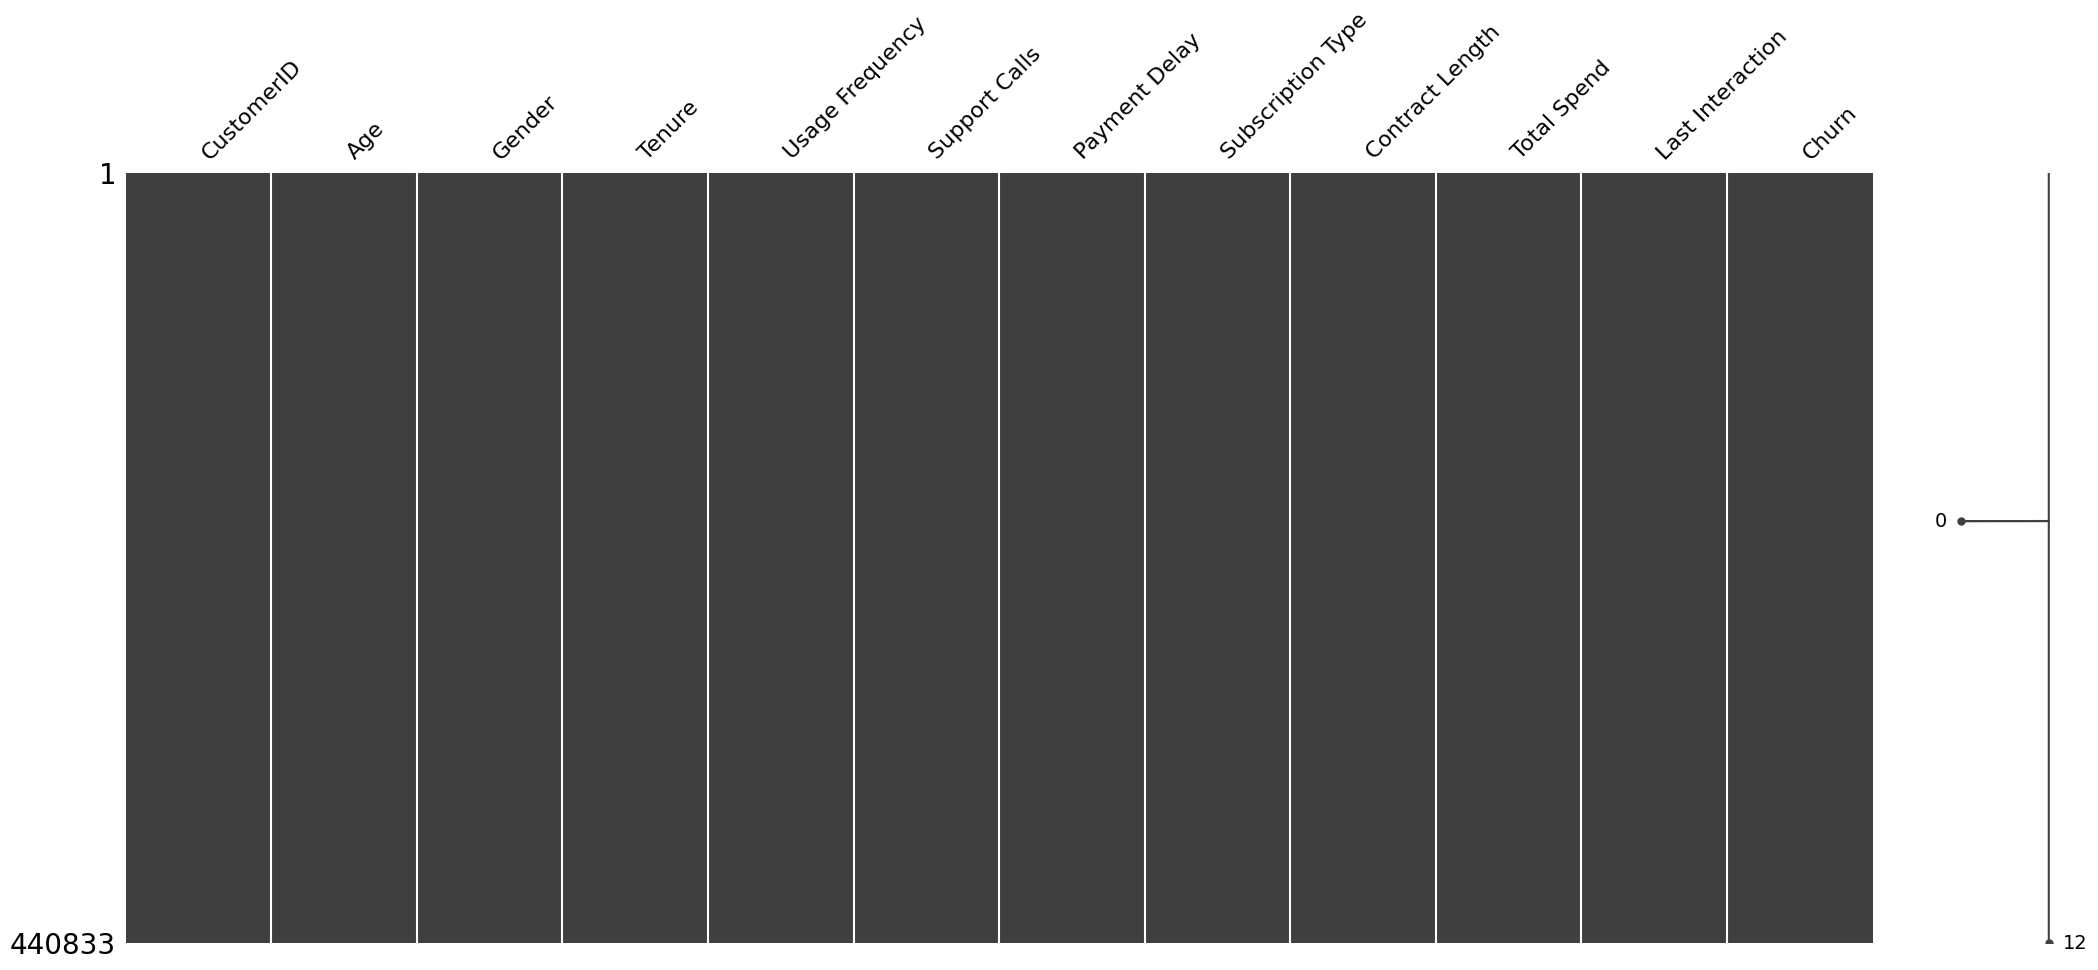

In [41]:
msno.matrix(train_df)

In [42]:
df = train_df.drop(columns = 'CustomerID') # Dropped customer ID as it's not a predictive feature
test_df = test_df.drop(columns = 'CustomerID')

In [43]:
list(df.columns)

['Age',
 'Gender',
 'Tenure',
 'Usage Frequency',
 'Support Calls',
 'Payment Delay',
 'Subscription Type',
 'Contract Length',
 'Total Spend',
 'Last Interaction',
 'Churn']

In [44]:
new_column_names = {col : col.replace(' ','_') for col in df.columns}
df = df.rename(columns = new_column_names)

In [45]:
list(df.columns)

['Age',
 'Gender',
 'Tenure',
 'Usage_Frequency',
 'Support_Calls',
 'Payment_Delay',
 'Subscription_Type',
 'Contract_Length',
 'Total_Spend',
 'Last_Interaction',
 'Churn']

In [46]:
df.isna().sum()

Age                  1
Gender               1
Tenure               1
Usage_Frequency      1
Support_Calls        1
Payment_Delay        1
Subscription_Type    1
Contract_Length      1
Total_Spend          1
Last_Interaction     1
Churn                1
dtype: int64

In [47]:
df[df['Age'].isna()]

,Age,Gender,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df = df.drop(199295)
df = df.reset_index(drop = True)
df

,Age,Gender,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.00,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
440827,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0.0
440828,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0.0
440829,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0.0
440830,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0.0


In [49]:
df.isna().sum()

Age                  0
Gender               0
Tenure               0
Usage_Frequency      0
Support_Calls        0
Payment_Delay        0
Subscription_Type    0
Contract_Length      0
Total_Spend          0
Last_Interaction     0
Churn                0
dtype: int64

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440832 entries, 0 to 440831
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  float64
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  float64
 3   Usage_Frequency    440832 non-null  float64
 4   Support_Calls      440832 non-null  float64
 5   Payment_Delay      440832 non-null  float64
 6   Subscription_Type  440832 non-null  object 
 7   Contract_Length    440832 non-null  object 
 8   Total_Spend        440832 non-null  float64
 9   Last_Interaction   440832 non-null  float64
 10  Churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 37.0+ MB


In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,440832.0,39.373153,12.442369,18.0,29.0,39.0,48.0,65.0
Tenure,440832.0,31.256336,17.255727,1.0,16.0,32.0,46.0,60.0
Usage_Frequency,440832.0,15.807494,8.586242,1.0,9.0,16.0,23.0,30.0
Support_Calls,440832.0,3.604437,3.070218,0.0,1.0,3.0,6.0,10.0
Payment_Delay,440832.0,12.965722,8.258063,0.0,6.0,12.0,19.0,30.0
Total_Spend,440832.0,631.616223,240.803001,100.0,480.0,661.0,830.0,1000.0
Last_Interaction,440832.0,14.480868,8.596208,1.0,7.0,14.0,22.0,30.0
Churn,440832.0,0.567107,0.495477,0.0,0.0,1.0,1.0,1.0


In [52]:
test_df.isna().sum()

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [53]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                64374 non-null  int64 
 1   Gender             64374 non-null  object
 2   Tenure             64374 non-null  int64 
 3   Usage Frequency    64374 non-null  int64 
 4   Support Calls      64374 non-null  int64 
 5   Payment Delay      64374 non-null  int64 
 6   Subscription Type  64374 non-null  object
 7   Contract Length    64374 non-null  object
 8   Total Spend        64374 non-null  int64 
 9   Last Interaction   64374 non-null  int64 
 10  Churn              64374 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 5.4+ MB


# =============================================
# Exploratory Data Analysis
# =============================================

## 1.Age Distribution and Churn Rate:

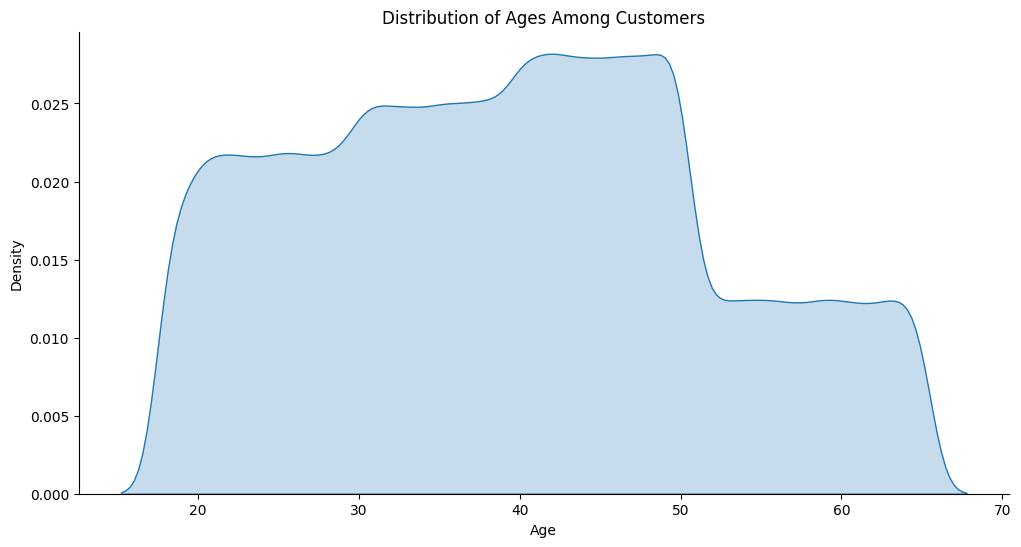

/tmp/ipykernel_449610/3424048934.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Age', data=df, palette='Set3')


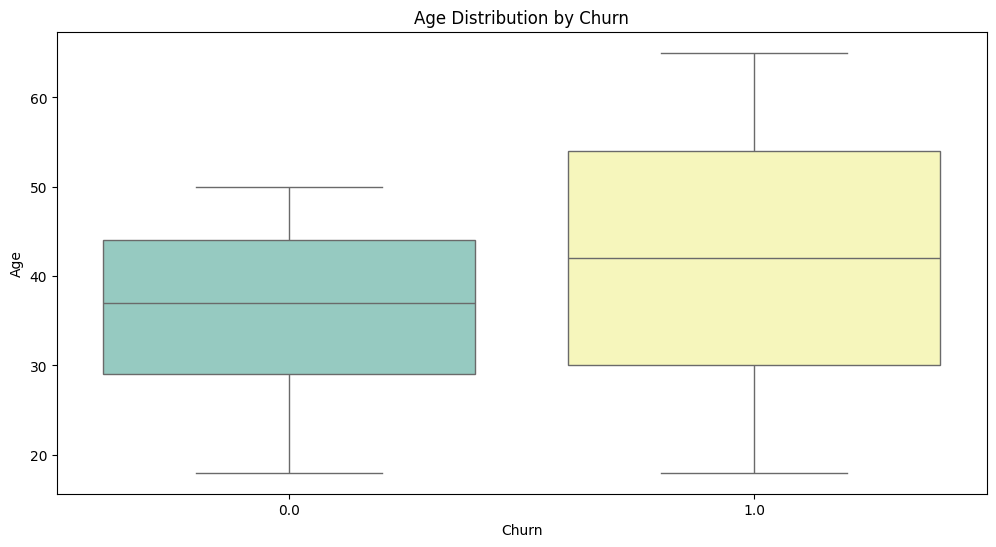

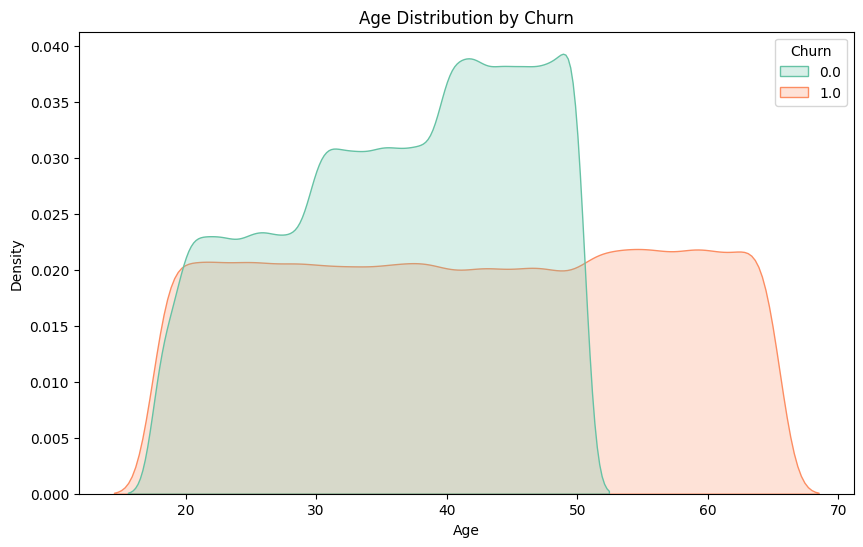


🔍 Churn Rate by Age Group:

AgeGroup
0-20     0.646084
21-30    0.539693
31-40    0.465106
41-50    0.405707
51-60    0.861049
61+      1.000000


/tmp/ipykernel_449610/3424048934.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_churn_rate = df.groupby('AgeGroup')['Churn'].mean()
/tmp/ipykernel_449610/3424048934.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_churn_rate.index, y=age_churn_rate.values, palette='pastel')


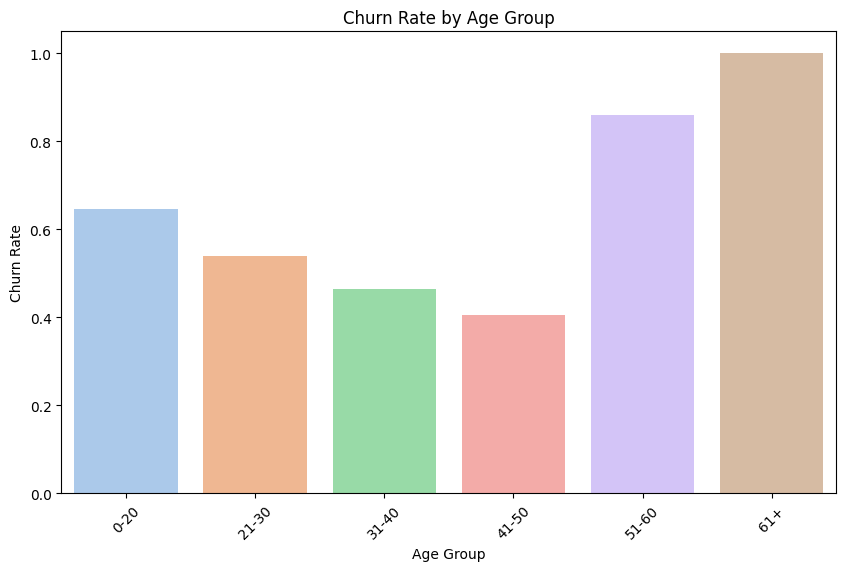


📊 Summary Statistics of Age by Churn:

          count   mean    std   min   25%   50%   75%   max
Churn                                                      
0.0    190833.0  36.26   9.20  18.0  29.0  37.0  44.0  50.0
1.0    249999.0  41.75  13.98  18.0  30.0  42.0  54.0  65.0


In [69]:
# KDE plot for age distribution
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='Age', fill=True, common_norm=False)
plt.title('Distribution of Ages Among Customers')
sns.despine()
plt.show()

# Boxplot: Age by churn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='Age', data=df, palette='Set3')
plt.xlabel('Churn')
plt.ylabel('Age')
plt.title('Age Distribution by Churn')
plt.show()

# KDE plot: Age distribution by churn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Age', hue='Churn', common_norm=False, fill=True, palette='Set2')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution by Churn')
plt.savefig('../images/age_distibution_by_churn.png')
plt.show()

# Create age bins
age_bins = [0, 20, 30, 40, 50, 60, float('inf')]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Calculate churn rate by age group
age_churn_rate = df.groupby('AgeGroup')['Churn'].mean()

# Print churn rates in console
print("\n🔍 Churn Rate by Age Group:\n")
print(age_churn_rate.to_string())

# Bar plot: Churn rate by age group
plt.figure(figsize=(10, 6))
sns.barplot(x=age_churn_rate.index, y=age_churn_rate.values, palette='pastel')
plt.xlabel('Age Group')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Age Group')
plt.xticks(rotation=45)
plt.savefig('../images/churn_by_age_group.png')
plt.show()

# Optional: Print summary stats of age per churn class
print("\n📊 Summary Statistics of Age by Churn:\n")
print(df.groupby('Churn')['Age'].describe().round(2))

### 🔍 Conclusions from Age Analysis:
#### 1. Age Strongly Correlates with Churn

    Young adults (0–20) have a very high churn rate of 64.6%.

    Churn rate steadily decreases with age up to the 41–50 group, where it's at its lowest (40.5%).

    However, churn spikes again dramatically for:

        51–60 age group: 86.1%

        61+ age group: 100% (although this group may be very small in size)

#### 2. Middle-aged customers (31–50) are the most stable:

    They have the lowest churn rates and likely represent the most loyal segment.

#### 3. Summary Statistics Support the Trend:

    Churned customers (mean age = 41.75) tend to be older than retained customers (mean = 36.26).

    The standard deviation is higher for churned users (13.98 vs 9.20), indicating more age variability among those who churn.

#### 🧠 Actionable Insights:

    Retention efforts should focus on:

        Younger users (under 30): Understand why they leave early—price, expectations, product fit?

        Older users (50+): Investigate usability, tech support needs, or health-related churn.

    Consider age-personalized campaigns or differentiated support/services for high-risk age groups.

## 2.Gender Analysis:

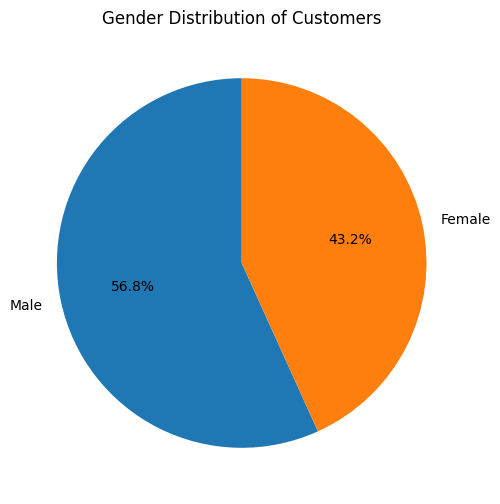

/tmp/ipykernel_449610/3534706456.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_churn_rate.index, y=gender_churn_rate.values, palette='Set2')


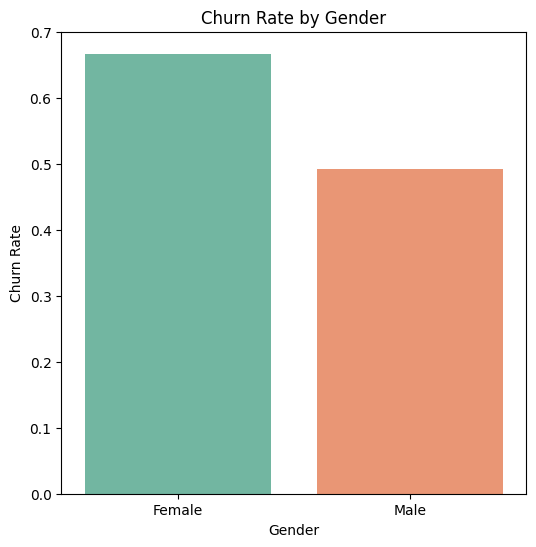

Gender Distribution:

         Count  Percentage
Gender                    
Male    250252       56.77
Female  190580       43.23

Churn Rate by Gender:

Gender
Female    0.6667
Male      0.4913
Name: Churn, dtype: float64


In [70]:
# Gender Distribution Plot
plt.figure(figsize=(6, 6))
gender_counts = df['Gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution of Customers')
plt.savefig('../images/gender_distribution.png')
plt.show()

# Churn Rate by Gender Plot
gender_churn_rate = df.groupby('Gender')['Churn'].mean()

plt.figure(figsize=(6, 6))
sns.barplot(x=gender_churn_rate.index, y=gender_churn_rate.values, palette='Set2')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Gender')
plt.savefig('../images/churn_rate_by_gender.png')
plt.show()

# Print Gender Distribution (Count and Percentage)
print("Gender Distribution:\n")
gender_percent = df['Gender'].value_counts(normalize=True) * 100
gender_dist_df = pd.DataFrame({
    'Count': gender_counts,
    'Percentage': gender_percent.round(2)
})
print(gender_dist_df)

# Print Churn Rate by Gender
print("\nChurn Rate by Gender:\n")
print(gender_churn_rate.round(4))

### 🔍 Gender-Based Insights

    Customer Demographics:

        The majority of customers are Male (56.77%), while Female customers account for 43.23% of the dataset.

        So, the customer base is slightly male-dominated.

    Churn Behavior:

        Female Churn Rate: 66.67%

        Male Churn Rate: 49.13%

        This indicates that female customers are significantly more likely to churn compared to male customers.

### ✅ Conclusion:

    Gender is a relevant factor in churn prediction.

    Female customers exhibit higher churn risk, and hence targeted retention strategies (e.g., personalized support, incentives, engagement campaigns) may be especially necessary for this segment.

## 3.Tenure and Churn:

/tmp/ipykernel_449610/1695138826.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tenure', y='Tenure', data=df, estimator=lambda x: len(x) / len(df) * 100, palette='Blues')


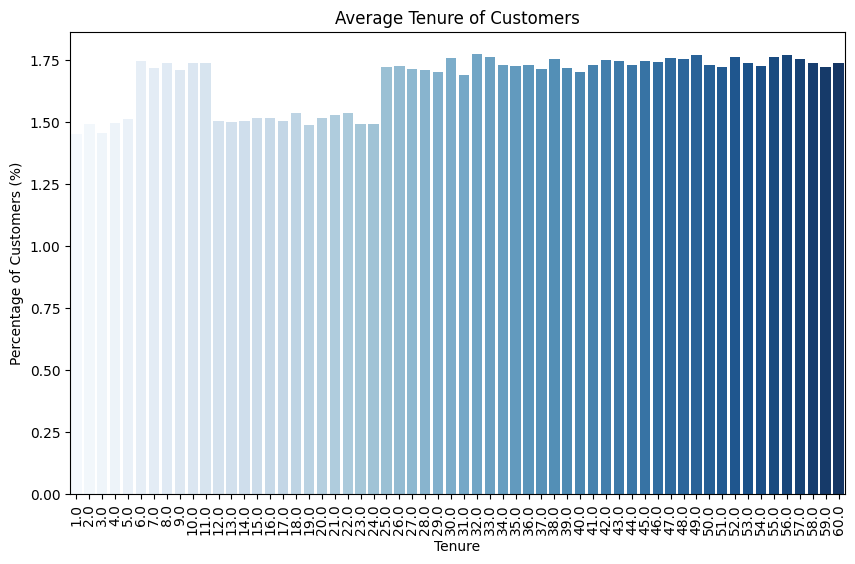

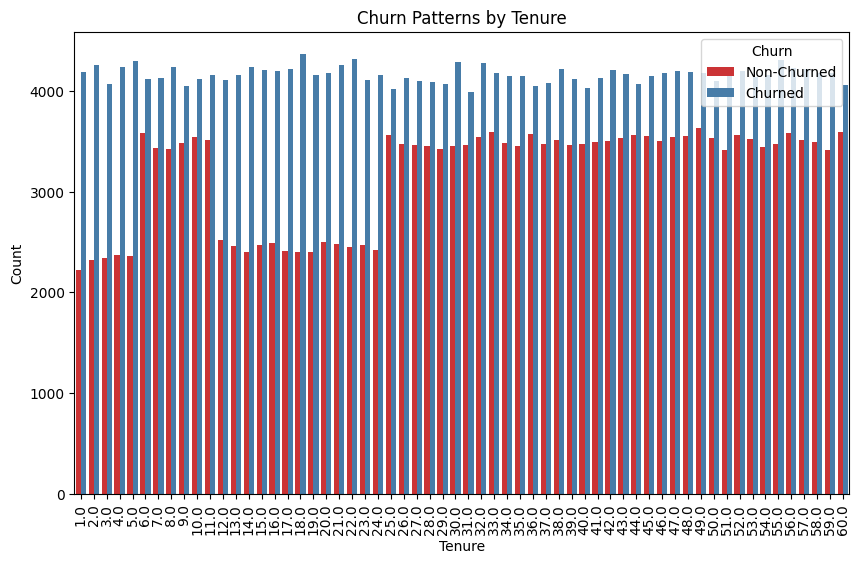

/tmp/ipykernel_449610/1695138826.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(x='Tenure', y='Churn', data=df, errorbar=None, palette='Set2')


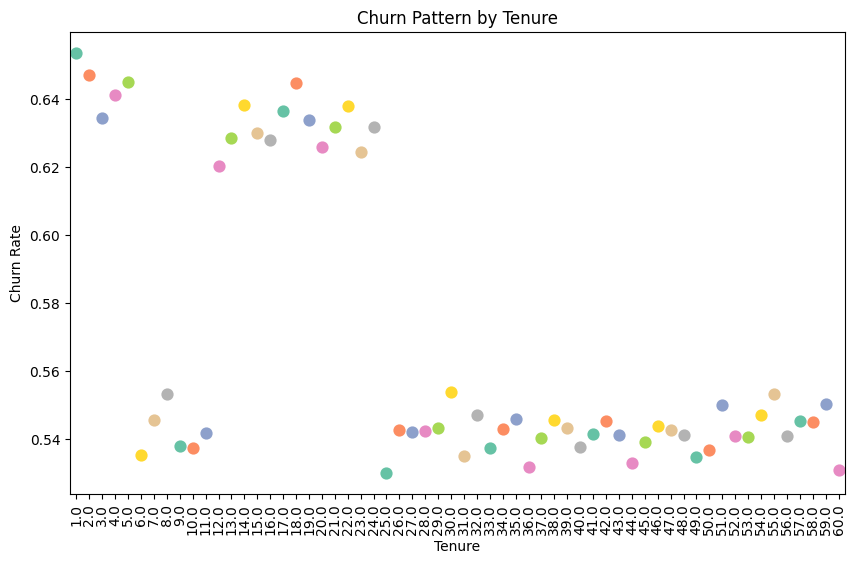

Average Tenure for Churned Customers: 30.47 months
Average Tenure for Retained Customers: 32.28 months

Churn Rate by Tenure:
Tenure
1.0     0.653660
2.0     0.647148
3.0     0.634409
4.0     0.641387
5.0     0.645074
6.0     0.535306
7.0     0.545779
8.0     0.553325
9.0     0.537961
10.0    0.537529
11.0    0.541781
12.0    0.620232
13.0    0.628628
14.0    0.638240
15.0    0.630106
16.0    0.628119
17.0    0.636652
18.0    0.644923
19.0    0.633983
20.0    0.625936
21.0    0.631743
22.0    0.637880
23.0    0.624373
24.0    0.631779
25.0    0.530094
26.0    0.542801
27.0    0.542135
28.0    0.542368
29.0    0.543333
30.0    0.553806
31.0    0.534987
32.0    0.547138
33.0    0.537323
34.0    0.543026
35.0    0.545789
36.0    0.531689
37.0    0.540272
38.0    0.545584
39.0    0.543321
40.0    0.537570
41.0    0.541596
42.0    0.545478
43.0    0.541288
44.0    0.533036
45.0    0.539200
46.0    0.543880
47.0    0.542662
48.0    0.541166
49.0    0.534613
50.0    0.536809
51.0    0.550171


In [71]:
# Plot the average tenure of customers
plt.figure(figsize=(10, 6))
sns.barplot(x='Tenure', y='Tenure', data=df, estimator=lambda x: len(x) / len(df) * 100, palette='Blues')
plt.xlabel('Tenure')
plt.ylabel('Percentage of Customers (%)')
plt.title('Average Tenure of Customers')
plt.xticks(rotation=90)
plt.show()

# Plot churn patterns by tenure
plt.figure(figsize=(10, 6))
sns.countplot(x='Tenure', hue='Churn', data=df, palette='Set1')
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.title('Churn Patterns by Tenure')
plt.legend(title='Churn', labels=['Non-Churned', 'Churned'])
plt.xticks(rotation=90)
plt.show()

# Plot churn rate pattern by tenure
plt.figure(figsize=(10, 6))
sns.pointplot(x='Tenure', y='Churn', data=df, errorbar=None, palette='Set2')
plt.xlabel('Tenure')
plt.ylabel('Churn Rate')
plt.title('Churn Pattern by Tenure')
plt.xticks(rotation=90)
plt.savefig('../images/churn_patter_by_tenure.png')
plt.show()

# Calculate and print average tenure for customers who churned and those who didn't
avg_tenure_churned = df[df['Churn'] == 1]['Tenure'].mean()
avg_tenure_retained = df[df['Churn'] == 0]['Tenure'].mean()

print(f'Average Tenure for Churned Customers: {avg_tenure_churned:.2f} months')
print(f'Average Tenure for Retained Customers: {avg_tenure_retained:.2f} months')

# Group by tenure and churn to calculate churn rate
tenure_churn_rate = df.groupby('Tenure')['Churn'].mean()

# Display churn rate for each tenure group
print("\nChurn Rate by Tenure:")
print(tenure_churn_rate)

# Show the results of tenure distribution
tenure_distribution = df['Tenure'].value_counts(normalize=True).sort_index()
print("\nTenure Distribution (Percentage of Customers):")
print(tenure_distribution * 100)  # Convert to percentage

### 1. Average Tenure of Churned vs Retained Customers:

    Churned Customers: On average, churned customers have a tenure of 30.47 months.

    Retained Customers: On average, retained customers have a slightly higher tenure of 32.28 months.

    Conclusion: Customers who stay longer with the service tend to have a slightly higher average tenure compared to customers who churn. This suggests that retention might be associated with longer service periods, while churn is more likely for customers who have been with the service for a shorter period.

### 2. Churn Rate by Tenure:

    The churn rate fluctuates across different tenure values, with some noticeable trends:

        Early Tenure (1-2 months): The churn rate is relatively high, around 65-66%. This indicates that customers who have been with the service for a very short time are more likely to churn.

        Moderate Tenure (6-10 months): The churn rate starts to decrease significantly, reaching around 53-54%.

        Longer Tenure (above 25 months): The churn rate remains relatively stable but slightly lower in comparison to earlier months, fluctuating between 53-55%.

        Conclusion: Customers with shorter tenures (especially those in the first few months) show a higher likelihood of churning. Over time, as customers stay longer, the churn rate stabilizes and slightly decreases, suggesting that some level of customer loyalty is built after a certain period.

### 3. Tenure Distribution:

    The tenure distribution shows that a large proportion of customers have a tenure between 1 and 12 months, with a peak between 30 and 60 months.

    Most customers have a tenure between 6 and 10 months, which aligns with the earlier observation that churn rates are highest in the first few months of service.

    Conclusion: The distribution shows that a significant portion of customers are relatively new (in the range of 1-12 months). As the tenure increases, the number of customers decreases, suggesting a natural attrition as time progresses, but the customers who stay longer tend to remain with the service.

### Summary of Insights:

    High churn in the early months of tenure suggests that customer acquisition strategies need to focus on improving retention during the initial period (e.g., through engagement, offering incentives, etc.).

    Long-tenure customers (those above 30 months) tend to churn at lower rates, indicating that customer retention improves over time. However, the churn rate does not significantly decrease beyond a certain tenure threshold.

    Customer retention programs may be more effective if targeted toward those in the first 6-12 months of their tenure, as they are most likely to churn.

    Slightly higher churn in customers with shorter tenure emphasizes the importance of improving early customer experiences to reduce early churn.

## 4.Usage Frequency:

/tmp/ipykernel_449610/2792784935.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Usage_Frequency', y='Usage_Frequency', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette='Blues')


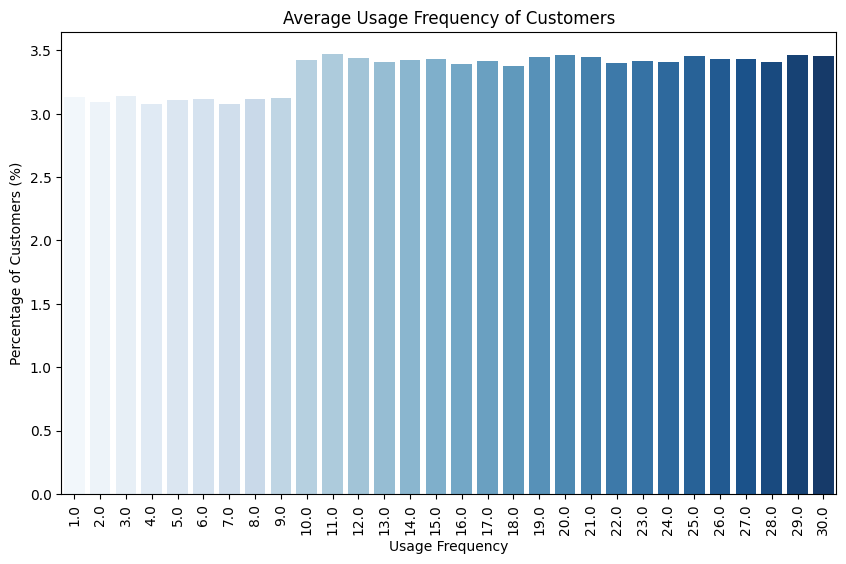

Average Usage Frequency: 15.81


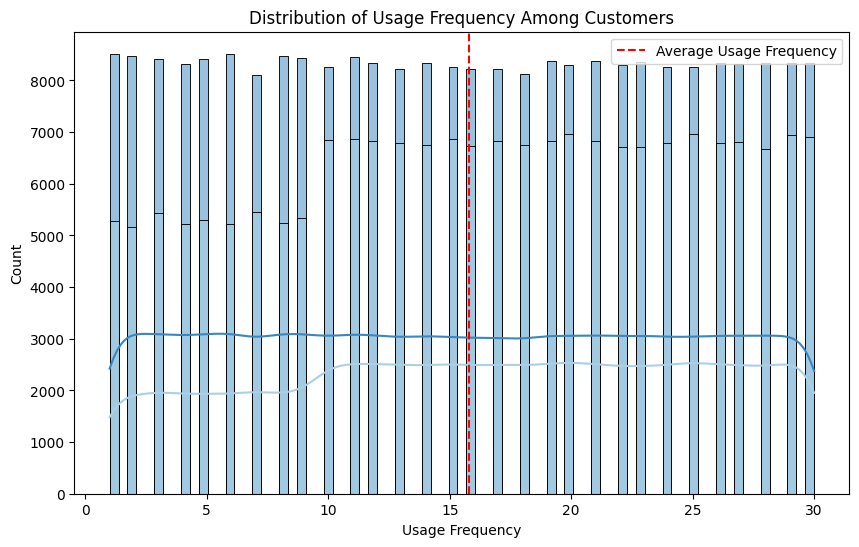

/tmp/ipykernel_449610/2792784935.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Churn', y='Usage_Frequency', data=df, palette='Set2')


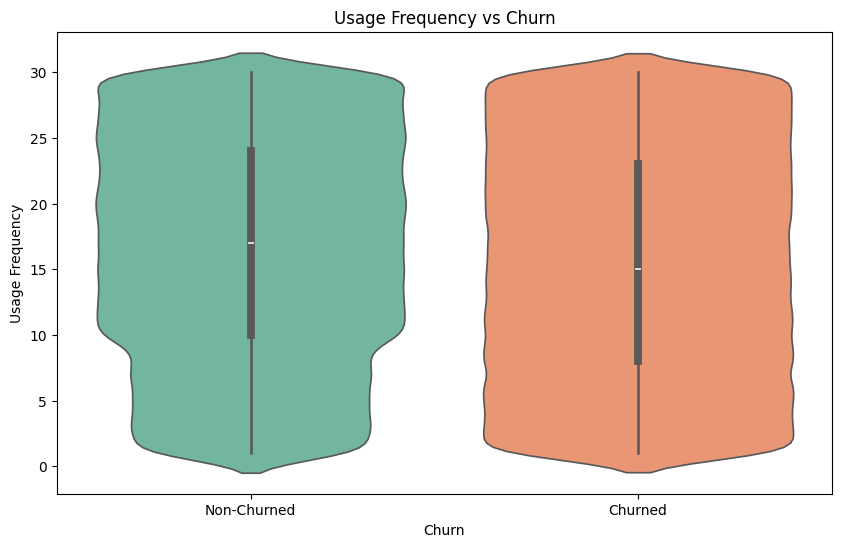

Average Usage Frequency for Churned Customers: 15.46
Average Usage Frequency for Non-Churned Customers: 16.26


In [57]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your dataframe
# Plot the average usage frequency
plt.figure(figsize=(10, 6))
sns.barplot(x='Usage_Frequency', y='Usage_Frequency', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette='Blues')
plt.xlabel('Usage Frequency')
plt.ylabel('Percentage of Customers (%)')
plt.title('Average Usage Frequency of Customers')
plt.xticks(rotation=90)
plt.show()

# Calculate average usage frequency
average_usage_frequency = df['Usage_Frequency'].mean()
print(f"Average Usage Frequency: {average_usage_frequency:.2f}")

# Plot the distribution of usage frequency among customers with churn status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Usage_Frequency', hue='Churn', kde=True, palette='Blues')
plt.axvline(average_usage_frequency, color='red', linestyle='dashed', label='Average Usage Frequency')
plt.xlabel('Usage Frequency')
plt.ylabel('Count')
plt.title('Distribution of Usage Frequency Among Customers')
plt.legend()
plt.show()

# Plot usage frequency vs churn
plt.figure(figsize=(10, 6))
sns.violinplot(x='Churn', y='Usage_Frequency', data=df, palette='Set2')
plt.xlabel('Churn')
plt.ylabel('Usage Frequency')
plt.title('Usage Frequency vs Churn')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.show()

# Additional output in console
churned_usage_frequency = df[df['Churn'] == 1]['Usage_Frequency'].mean()
non_churned_usage_frequency = df[df['Churn'] == 0]['Usage_Frequency'].mean()

print(f"Average Usage Frequency for Churned Customers: {churned_usage_frequency:.2f}")
print(f"Average Usage Frequency for Non-Churned Customers: {non_churned_usage_frequency:.2f}")

### Conclusion:

#### From the analysis, we can conclude the following:

    Average Usage Frequency:

        The overall average usage frequency of customers is 15.81.

    Churned Customers:

        The average usage frequency for churned customers is 15.46, which is slightly lower than the overall average.

    Non-Churned Customers:

        The average usage frequency for non-churned customers is 16.26, which is higher than the overall average and also higher than the churned customers.

### Insights:

    Customers who churn tend to have a lower average usage frequency (15.46) compared to those who remain (16.26). This suggests that customers who use the service more frequently are less likely to churn.

    This indicates a potential correlation between higher usage frequency and lower churn rates, where more engaged customers are more likely to stay with the service.

### Recommendation:

    To reduce churn, the company could focus on increasing the engagement of lower-frequency users, possibly through targeted offers, reminders, or features that encourage more frequent usage of the service.


## 5.Support Calls and Churn :

Average Number of Support Calls: 3.6044366107723578


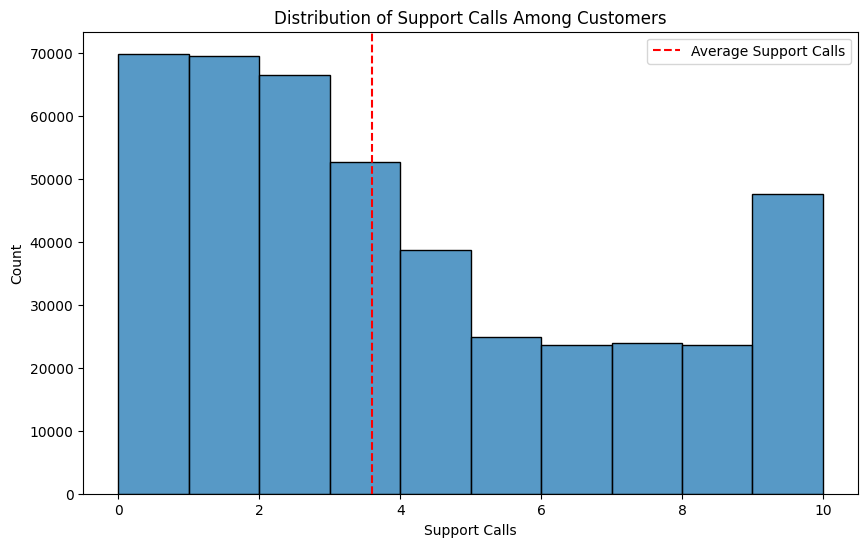

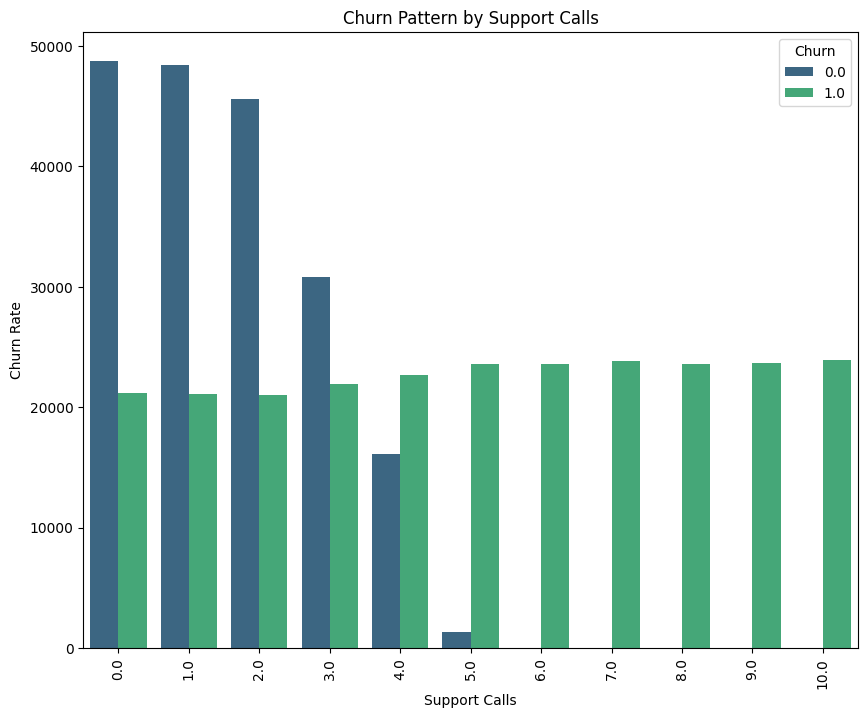


Churn Rate by Number of Support Calls:
Support_Calls
0.0     0.302826
1.0     0.303630
2.0     0.315513
3.0     0.416431
4.0     0.584981
5.0     0.947147
6.0     1.000000
7.0     1.000000
8.0     1.000000
9.0     1.000000
10.0    1.000000
Name: Churn, dtype: float64


In [58]:
# Calculate the average number of support calls
average_support_calls = df['Support_Calls'].mean()
print(f"Average Number of Support Calls: {average_support_calls}")

# Plot the distribution of support calls
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Support_Calls', bins=10)
plt.axvline(average_support_calls, color='red', linestyle='dashed', label='Average Support Calls')
plt.xlabel('Support Calls')
plt.ylabel('Count')
plt.title('Distribution of Support Calls Among Customers')
plt.legend()
plt.show()

# Plot the churn pattern by the number of support calls
plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='Support_Calls', hue='Churn', palette='viridis')
plt.xlabel('Support Calls')
plt.ylabel('Churn Rate')
plt.title('Churn Pattern by Support Calls')
plt.xticks(rotation=90)
plt.show()

# Displaying the correlation between support calls and churn
support_churn_correlation = df.groupby('Support_Calls')['Churn'].mean()
print(f"\nChurn Rate by Number of Support Calls:\n{support_churn_correlation}")


### 🔍 Insights:

    Average Support Calls:

        On average, customers made approximately 3.6 support calls.

    Churn Rate Trend:

        Customers with 0–2 support calls have a relatively low churn rate (around 30%).

        Starting from 3 support calls, the churn rate increases significantly.

        At 4 support calls, the churn rate jumps to ~58%.

        For customers making 5 or more support calls, the churn rate exceeds 94%, and hits 100% from 6 calls onwards.

### Conclusion:
    There is a strong positive correlation between the number of support calls and churn rate.
This suggests that as customers encounter more issues or require frequent support, they are far more likely to leave the service.

### 💡 Implication: 
        High support call volume could be a red flag. Businesses should proactively address customer concerns and improve first-contact resolution to reduce churn.

## 6.Payment Delay :

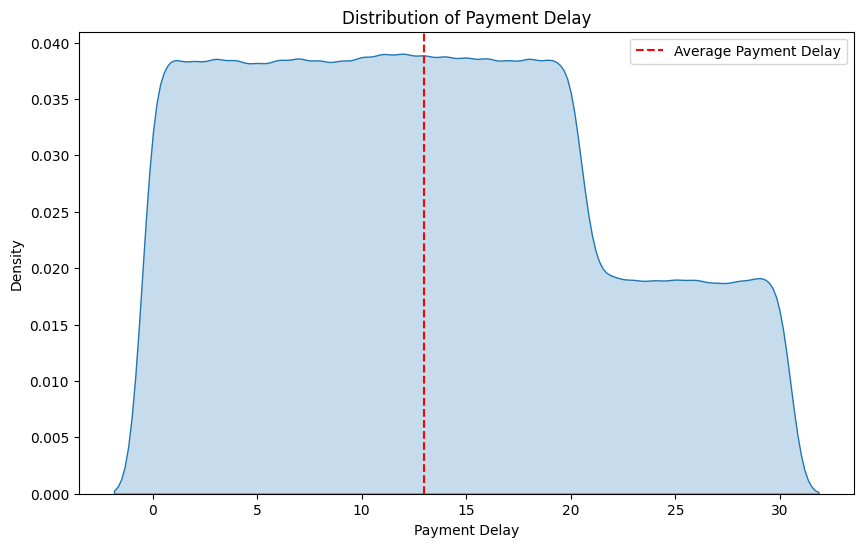

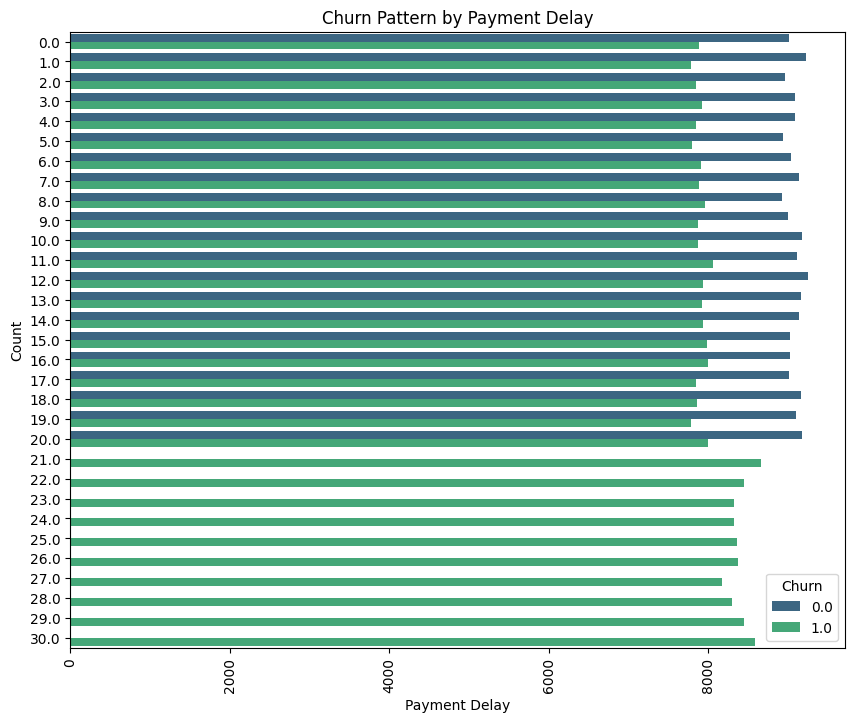

Average Payment Delay: 12.97

Churn Rate by Payment Delay:
Payment_Delay
0.0     0.466694
1.0     0.457846
2.0     0.466829
3.0     0.465786
4.0     0.463573
5.0     0.466197
6.0     0.466851
7.0     0.463264
8.0     0.471170
9.0     0.466596
10.0    0.461498
11.0    0.469305
12.0    0.461682
13.0    0.463820
14.0    0.464809
15.0    0.469468
16.0    0.469714
17.0    0.465173
18.0    0.461679
19.0    0.460869
20.0    0.465560
21.0    1.000000
22.0    1.000000
23.0    1.000000
24.0    1.000000
25.0    1.000000
26.0    1.000000
27.0    1.000000
28.0    1.000000
29.0    1.000000
30.0    1.000000
Name: Churn, dtype: float64


In [59]:
# Plotting the distribution of Payment Delay
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Payment_Delay', fill=True)
plt.title('Distribution of Payment Delay')
avg_payment_delay = df['Payment_Delay'].mean()
plt.xlabel('Payment Delay')
plt.axvline(avg_payment_delay, color='red', linestyle='dashed', label='Average Payment Delay')
plt.legend()
plt.show()

# Visualizing churn distribution by payment delay
plt.figure(figsize=(10, 8))
sns.countplot(data=df, y='Payment_Delay', hue='Churn', palette='viridis')
plt.xlabel('Payment Delay')
plt.ylabel('Count')
plt.title('Churn Pattern by Payment Delay')
plt.xticks(rotation=90)
plt.show()

# Print insights in console
print(f"Average Payment Delay: {avg_payment_delay:.2f}")

# Churn rate by payment delay
churn_rate_by_payment_delay = df.groupby('Payment_Delay')['Churn'].mean()
print("\nChurn Rate by Payment Delay:")
print(churn_rate_by_payment_delay)

### 📊 Conclusion Based on Payment Delay and Churn Analysis:

    From the data:

    The average payment delay among customers is approximately 12.97 days.

    For delays up to around 20 days, the churn rate remains fairly stable (~46-47%).

    Beyond 21 days, the churn rate jumps to 100%, indicating that customers with very high payment delays are extremely likely to churn.



## 7.Subscription Type and Contract Length

In [60]:
# Display proportions of each subscription type
subscription_counts = df['Subscription_Type'].value_counts(normalize=True) * 100
print("Subscription Type Proportions (%):")
print(subscription_counts)

# Display churn rate by subscription type
subscription_churn_rate = df.groupby('Subscription_Type')['Churn'].mean() * 100
print("\nChurn Rate by Subscription Type (%):")
print(subscription_churn_rate)

# Count non-churned customers with Monthly contracts
monthly_non_churned = df[(df['Contract_Length'] == 'Monthly') & (df['Churn'] == 0)]
print(f"\nNumber of non-churned customers with Monthly contracts: {len(monthly_non_churned)}")

Subscription Type Proportions (%):
Subscription_Type
Standard    33.828760
Premium     33.726680
Basic       32.444559
Name: proportion, dtype: float64

Churn Rate by Subscription Type (%):
Subscription_Type
Basic       58.178233
Premium     55.941700
Standard    56.069953
Name: Churn, dtype: float64

Number of non-churned customers with Monthly contracts: 0


### 🔍 Insights and Conclusion:

    Balanced Subscription Distribution:

        Customers are fairly evenly distributed among the three subscription types: Standard (33.8%), Premium (33.7%), and Basic (32.4%).

    Churn Rate Comparison:

        All subscription types exhibit similarly high churn rates:
        Basic (58.18%), Premium (55.94%), and Standard (56.07%).

        This suggests that subscription type alone may not significantly influence churn behavior.

    Contract Length Insight:

        No customers with monthly contracts have remained active (i.e., all have churned).

        This strongly suggests that short-term contracts are highly associated with churn, indicating the need for strategies to encourage longer commitments.


## 8.Total Spend and Churn


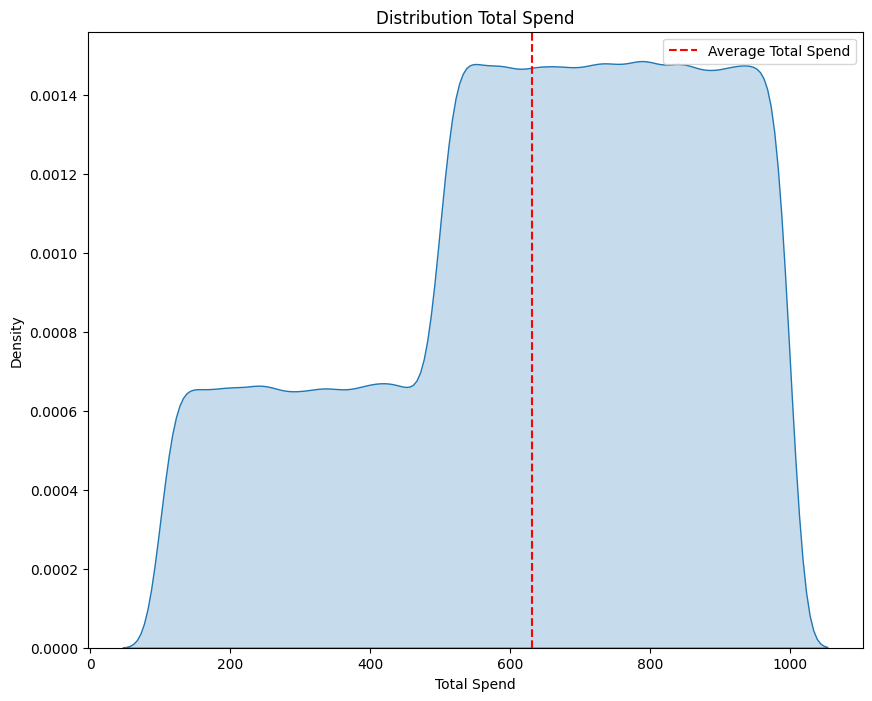

In [62]:
plt.figure(figsize = (10,8))
sns.kdeplot(data = df , x = 'Total_Spend' , fill = True )
plt.title('Distribution Total Spend')
avg_total_spend = df.Total_Spend.mean()
plt.xlabel('Total Spend')
plt.axvline(avg_total_spend , color = 'red' , linestyle = 'dashed' , label = 'Average Total Spend')
plt.legend()
plt.savefig('../images/total_spend_distribution.png')
plt.show()

/tmp/ipykernel_449610/4221181987.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Total_Spend', data=df, palette='Set2')


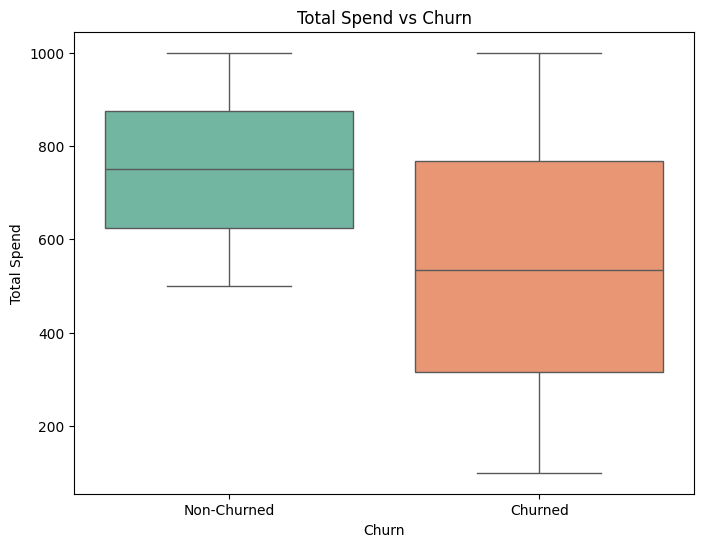

In [63]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='Total_Spend', data=df, palette='Set2')
plt.xlabel('Churn')
plt.ylabel('Total Spend')
plt.title('Total Spend vs Churn')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.savefig('../images/total_spend_vs_churn.png')
plt.show()

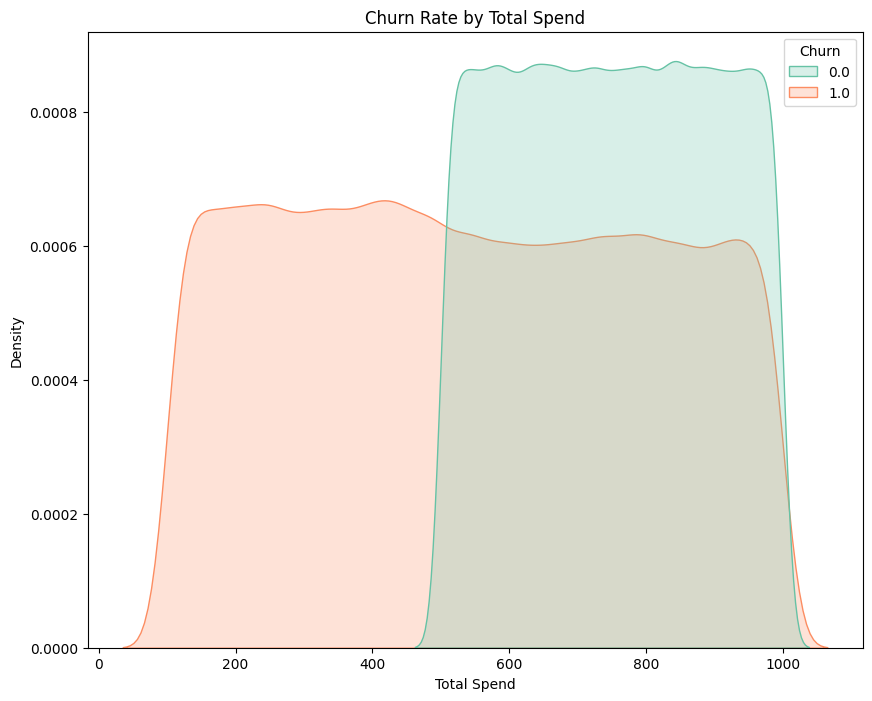

In [64]:
plt.figure(figsize = (10,8))
sns.kdeplot(data = df , x = 'Total_Spend' ,hue = 'Churn', fill = True , palette = 'Set2')
plt.title('Churn Rate by Total Spend')
plt.xlabel('Total Spend')
plt.savefig('../images/churn_by_total_spend.png')
plt.show()

In [31]:
# Average total spend
avg_total_spend = df['Total_Spend'].mean()
print(f"Average Total Spend: {avg_total_spend:.2f}")

# Average spend for churned and non-churned customers
spend_by_churn = df.groupby('Churn')['Total_Spend'].mean()
print("\nAverage Total Spend by Churn Status:")
print(spend_by_churn)

# Correlation between Total Spend and Churn
correlation = df['Total_Spend'].corr(df['Churn'])
print(f"\nCorrelation between Total Spend and Churn: {correlation:.4f}")

Average Total Spend: 631.62

Average Total Spend by Churn Status:
Churn
0.0    749.953111
1.0    541.285528
Name: Total_Spend, dtype: float64

Correlation between Total Spend and Churn: -0.4294


### 🔍 Key Insights: Total Spend and Churn

    Average Spending Difference:

        The overall average total spend is $631.62.

        Non-churned customers spend significantly more on average ($749.95) compared to churned customers ($541.29).

        This indicates that higher-spending customers are more likely to stay with the company.

    Negative Correlation with Churn:

        The correlation coefficient between total spend and churn is -0.4294, indicating a moderate negative relationship.

        In simple terms, as total spend increases, the likelihood of churn decreases.

    Interpretation:

        Valuable customers (high spenders) are less likely to churn.

        This insight could help in identifying and retaining high-value customers by offering them loyalty benefits or tailored support.




## 9.Last Interaction


Average Last Interaction: 14.480867995063878
Churn Rate by Last Interaction:
Last_Interaction
1.0     0.488133
2.0     0.494569
3.0     0.495482
4.0     0.490465
5.0     0.491382
6.0     0.491998
7.0     0.493969
8.0     0.489858
9.0     0.494798
10.0    0.491100
11.0    0.494912
12.0    0.492465
13.0    0.493985
14.0    0.490609
15.0    0.496418
16.0    0.665103
17.0    0.661481
18.0    0.662525
19.0    0.665102
20.0    0.662790
21.0    0.665955
22.0    0.667770
23.0    0.669329
24.0    0.661677
25.0    0.668412
26.0    0.665835
27.0    0.661297
28.0    0.662302
29.0    0.669054
30.0    0.666113
Name: Churn, dtype: float64
Correlation between Last Interaction and Churn: 0.1496159972494958


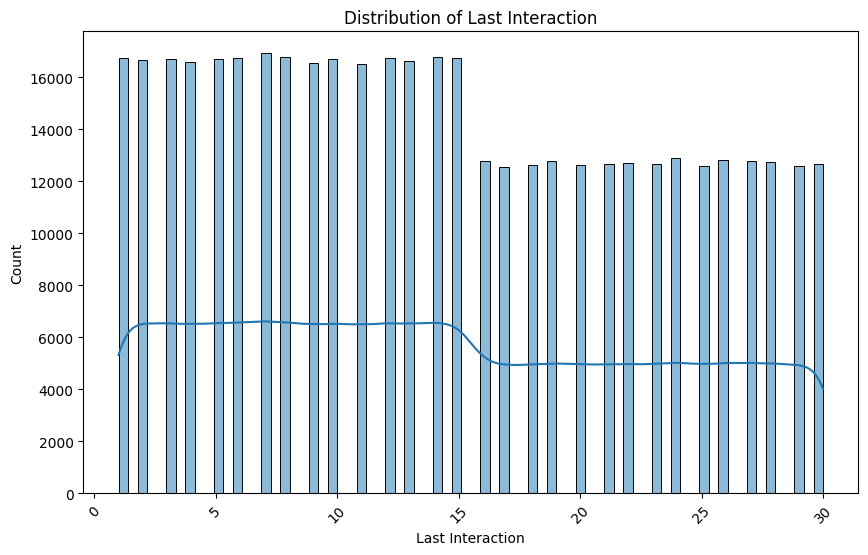

/tmp/ipykernel_449610/1108416677.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Churn', y='Last_Interaction', data=df, palette='Set3')


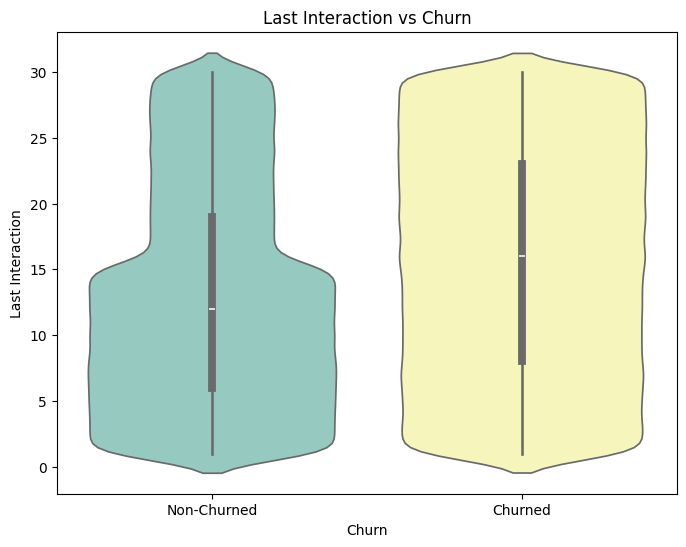

In [65]:
# Calculate average Last Interaction
average_last_interaction = df['Last_Interaction'].mean()
print(f"Average Last Interaction: {average_last_interaction}")

# Churn Rate by Last Interaction
churn_rate_by_last_interaction = df.groupby('Last_Interaction')['Churn'].mean()
print("Churn Rate by Last Interaction:")
print(churn_rate_by_last_interaction)

# Correlation between Last Interaction and Churn
correlation_last_interaction_churn = df['Last_Interaction'].corr(df['Churn'])
print(f"Correlation between Last Interaction and Churn: {correlation_last_interaction_churn}")

# Plot the distribution of Last Interaction
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Last_Interaction', kde=True)
plt.xlabel('Last Interaction')
plt.ylabel('Count')
plt.title('Distribution of Last Interaction')
plt.xticks(rotation=45)
plt.savefig('../images/histogram_last_interaction.png')
plt.show()

# Plot Last Interaction vs Churn using a violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Churn', y='Last_Interaction', data=df, palette='Set3')
plt.xlabel('Churn')
plt.ylabel('Last Interaction')
plt.title('Last Interaction vs Churn')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.savefig('../images/violin_plot_last_interaction.png')
plt.show()


    Average Last Interaction: The average last interaction is approximately 14.48. This suggests that, on average, customers have interacted with the service around this point in time.

    Churn Rate by Last Interaction:

        There is a gradual increase in the churn rate as the number of the last interaction increases, especially between interactions 16 to 30, where the churn rate reaches its peak.

        For customers with fewer interactions (1 to 15), the churn rate is relatively stable and lower (around 49%).

        The highest churn rate is observed at interactions 16 and higher, peaking at interactions 30, where the churn rate is over 66%.

    Correlation between Last Interaction and Churn:

        The correlation between the "Last Interaction" and "Churn" is 0.15, indicating a weak positive relationship between the two variables.

        Although there is some correlation, it is not strong enough to consider the recency of interaction as a major factor in predicting churn on its own. However, it suggests that customers who interacted more recently tend to have a higher likelihood of churning, especially those whose last interaction is around the later stages (post 16).

    These insights suggest that the timing of the last interaction may be an indicator of churn, especially for customers who interacted most recently. However, more factors would need to be considered to better understand and predict churn behavior.


## 10.Churn Analysis (Target Variable)


Overall Churn Rate: 56.71%


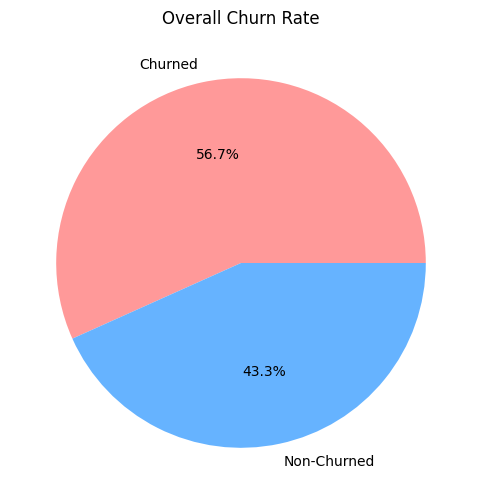

/tmp/ipykernel_449610/892175723.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette='viridis')


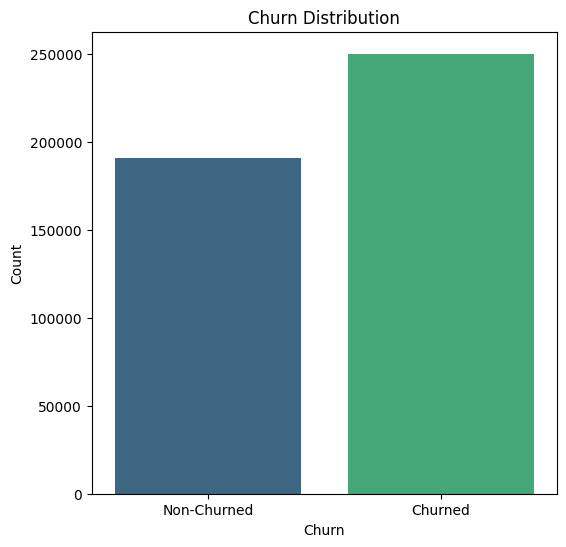

In [68]:
# Calculate overall churn rate
overall_churn_rate = df['Churn'].mean() * 100
print(f"Overall Churn Rate: {overall_churn_rate:.2f}%")

# Plot Overall Churn Rate as a Pie chart
plt.figure(figsize=(6, 6))
plt.pie([overall_churn_rate, 100 - overall_churn_rate], labels=['Churned', 'Non-Churned'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Overall Churn Rate')
plt.savefig('../images/churn_rate_pie_chart.png')
plt.show()

# Plot Churn Distribution as a Countplot
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='Churn', palette='viridis')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Churn Distribution')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.savefig('../images/churn_distribution_countplot.png')
plt.show()


#### 11.Correlations

    Are there any notable correlations between different features and churn?

    Could multicollinearity between features affect your analysis?


Correlation between features and Churn:
                     Churn
Age               0.218394
Tenure           -0.051919
Usage_Frequency  -0.046101
Support_Calls     0.574267
Payment_Delay     0.312129
Total_Spend      -0.429355
Last_Interaction  0.149616
Churn             1.000000


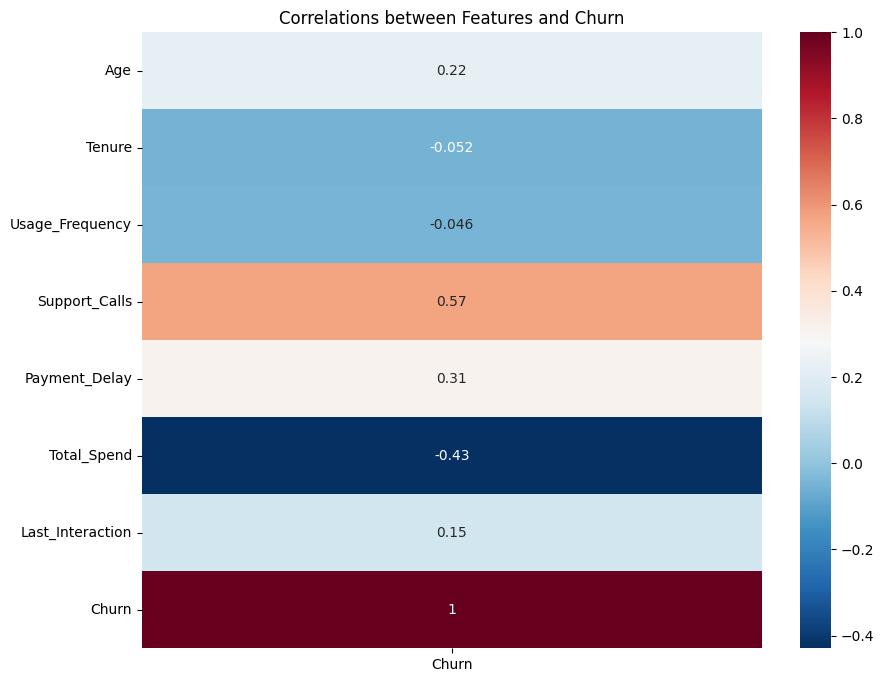


Highly Correlated Features with Churn:
Support_Calls: 0.5742671326590044
Total_Spend: 0.4293548243215598
Payment_Delay: 0.31212927574132066
Age: 0.21839391857714757
Last_Interaction: 0.14961599724951039


/tmp/ipykernel_449610/4203870260.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_corr_vars, y=high_corr_values, palette='RdBu_r')


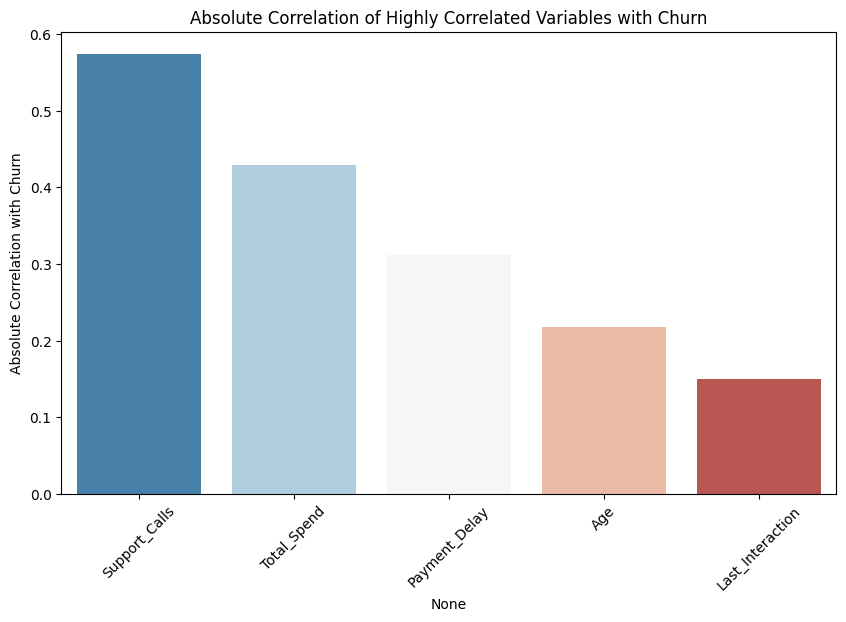


Features with high multicollinearity (correlation > 0.2):
['Support_Calls', 'Total_Spend']


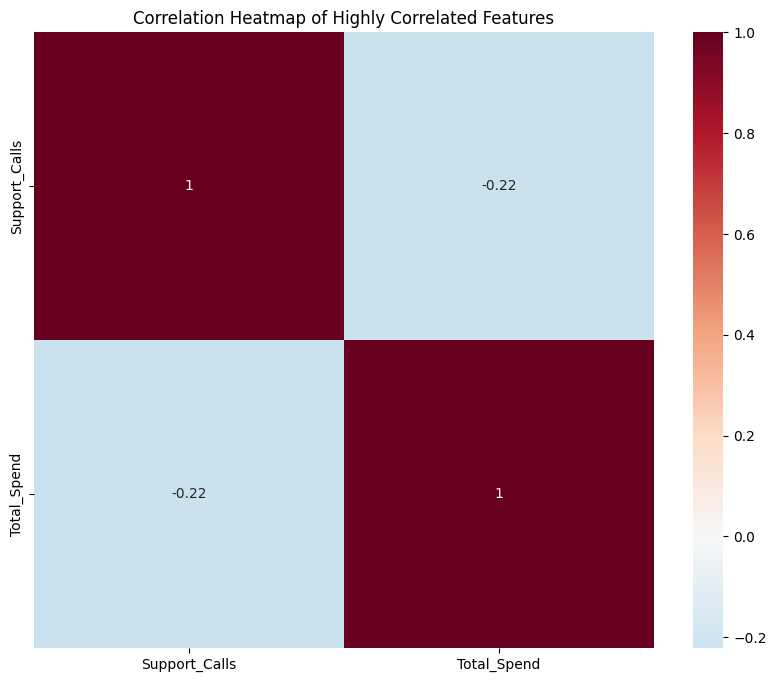

In [74]:
# Correlation matrix for all numerical columns, focusing on 'Churn'
corr_matrix = df.corr(numeric_only=True)

# Display the correlation matrix with 'Churn' in focus
print("Correlation between features and Churn:")
print(corr_matrix[['Churn']])

# Plotting the heatmap for correlations with 'Churn'
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['Churn']], annot=True, cmap='RdBu_r')
plt.title('Correlations between Features and Churn')
plt.savefig('../images/corr_bw_features_and_churn.png')
plt.show()

# Identifying the most highly correlated features with 'Churn'
high_corr_vars = corr_matrix.abs().nlargest(6, 'Churn')['Churn'].index[1:]
high_corr_values = corr_matrix.abs().nlargest(6, 'Churn')['Churn'].values[1:]

print("\nHighly Correlated Features with Churn:")
for var, value in zip(high_corr_vars, high_corr_values):
    print(f"{var}: {value}")

# Plotting the bar plot of highly correlated features
plt.figure(figsize=(10, 6))
sns.barplot(x=high_corr_vars, y=high_corr_values, palette='RdBu_r')
plt.ylabel('Absolute Correlation with Churn')
plt.title('Absolute Correlation of Highly Correlated Variables with Churn')
plt.xticks(rotation=45)
plt.savefig('../images/highly_correlated_variables.png')
plt.show()

# Correlation matrix excluding 'Churn' for multicollinearity check
corr_matrix = df.drop(columns=['Churn']).corr(numeric_only=True)

# Identifying features that have significant correlation with other features
high_corr_features = []
for column in corr_matrix.columns:
    max_corr = corr_matrix[column].drop(index=column).abs().max()
    if max_corr > 0.2:
        high_corr_features.append(column)

print("\nFeatures with high multicollinearity (correlation > 0.2):")
print(high_corr_features)

# Plotting the heatmap for highly correlated features
plt.figure(figsize=(10, 8))
sns.heatmap(df[high_corr_features].corr(), annot=True, cmap='RdBu_r', center=0)
plt.title('Correlation Heatmap of Highly Correlated Features')
plt.savefig('../images/heatmap_highly_correlated_feature.png')
plt.show()

### Analysis of Correlation Results
#### 1. Correlation between Features and Churn:

    Support Calls (0.574): This feature shows the highest correlation with churn, indicating that customers who have a higher number of support calls tend to churn more frequently. This suggests that frequent support calls could be a symptom of dissatisfaction or unresolved issues, leading to higher churn rates.

    Total Spend (-0.429): This negative correlation indicates that customers who spend less tend to have a higher churn rate. This could imply that customers who spend less on services or products may be less satisfied or engaged with the service and are more likely to leave.

    Payment Delay (0.312): There is a moderate positive correlation with churn, meaning that customers who experience delays in payment are more likely to churn. This could reflect financial instability or dissatisfaction with payment terms or service delivery, leading to customers discontinuing their subscriptions.

    Age (0.218): A weak positive correlation with churn, suggesting that older customers tend to have slightly higher churn rates. However, this relationship is not as strong as others, and other factors likely contribute more significantly to the churn behavior.

    Last Interaction (0.149): A very weak positive correlation, implying that the recency of the last interaction has little to no impact on churn. This could indicate that customers who interact recently with the service are not necessarily more likely to churn, and factors like satisfaction and service usage might play a more crucial role.

#### 2. Highly Correlated Features with Churn:

    The top five features most correlated with churn are:

        Support Calls (0.574)

        Total Spend (-0.429)

        Payment Delay (0.312)

        Age (0.218)

        Last Interaction (0.149)

    Support Calls and Total Spend stand out as the most significant predictors of churn, with Support Calls being the strongest. Thus, addressing customer issues early via customer support or focusing on increasing the spend of existing customers could help reduce churn.

#### 3. Multicollinearity:

    The features showing high multicollinearity (correlation above 0.2) are:

        Support Calls

        Total Spend

    Support Calls and Total Spend have a significant correlation with each other, which suggests that these two features are related. For instance, customers who call support frequently might also be spending less or more, depending on the nature of the issue (e.g., cost issues or service usage concerns). The correlation between these two features might introduce redundancy in models, which can affect the stability of regression models and the interpretation of coefficients.

    Impact of Multicollinearity: When using these correlated features in modeling, it could lead to overfitting or instability in predicting churn. One way to handle this would be to reduce dimensionality (e.g., using PCA) or dropping one of the correlated features (e.g., dropping Support Calls or Total Spend) if it does not add significant value after model training.

### Key Insights:

    Support Calls and Total Spend are the strongest predictors of churn, with a moderate negative correlation between Total Spend and churn. This suggests a relationship between customer dissatisfaction (expressed through support calls) and lower spending, which increases churn likelihood.

    Payment Delays also show a moderate correlation with churn, suggesting that customers with payment issues are more likely to leave the service.

    Age and Last Interaction have weaker correlations with churn, meaning other factors are more influential in predicting churn behavior.

    Multicollinearity between Support Calls and Total Spend could affect modeling. It is essential to handle these correlated features properly to avoid model instability.

In [49]:
df

,Age,Gender,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,Churn,AgeGroup
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,1.0,31-40
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,1.0,61+
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,1.0,51-60
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,1.0,51-60
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.00,20.0,1.0,21-30
...,...,...,...,...,...,...,...,...,...,...,...,...
440827,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0.0,41-50
440828,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0.0,21-30
440829,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0.0,21-30
440830,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0.0,21-30


In [50]:
joblib.dump(df, f'../datasets/processed_data.pkl')

['../datasets/processed_data.pkl']

# =============================================
# ENHANCED FEATURE ENGINEERING BASED ON EDA
# =============================================

In [51]:
def preprocess(df):
    
    df = df.drop(columns=['CustomerID'], errors='ignore')
    df = df.rename(columns=lambda x: x.replace(' ', '_'))
    
    # 1. Age Features (from EDA: 20-30 and >60 have highest churn)
    df['AgeGroup'] = pd.cut(df['Age'], 
                        bins=[0, 20, 30, 40, 50, 60, float('inf')],
                        labels=['0-20', '21-30', '31-40', '41-50', '51-60', '61+'])
    df['Is_Young_Adult'] = (df['Age'].between(20, 30)).astype(int)
    df['Is_Senior'] = (df['Age'] > 60).astype(int)

    # 2. Tenure Features (from EDA: new customers and 12-24 month tenure churn more)
    df['TenureGroup'] = pd.cut(df['Tenure'], 
                              bins=[0, 5, 12, 24, 36, float('inf')], 
                              labels=['0-5', '6-12', '13-24', '25-36', '37+'])
    df['Is_New_Customer'] = (df['Tenure'] <= 5).astype(int)
    df['Is_Mid_Tenure'] = (df['Tenure'].between(12, 24)).astype(int)

    # 3. Support Call Features (from EDA: >5 calls = 100% churn)
    df['High_Support_Calls'] = (df['Support_Calls'] > 5).astype(int)
    df['Medium_Support_Calls'] = ((df['Support_Calls'] > 3) & (df['Support_Calls'] <= 5)).astype(int)
    df['Support_Calls_per_Usage'] = df['Support_Calls'] / (df['Usage_Frequency'] + 0.1)

    # 4. Payment Delay Features (from EDA: 0-20 month delay has high churn)
    df['Payment_Delay_Group'] = pd.cut(df['Payment_Delay'], 
                                 bins=[-1, 5, 20, float('inf')], 
                                 labels=['0-5', '6-20', '21+'])
    df['Has_Payment_Delay_Issue'] = (df['Payment_Delay'] <= 20).astype(int)

    # 5. Gender Features (from EDA: Females churn more)
    df['Is_Female'] = (df['Gender'] == 'Female').astype(int)
    df['Female_High_Support'] = ((df['Gender'] == 'Female') & (df['Support_Calls'] > 3)).astype(int)

    # 6. Subscription Features (from EDA: Monthly contracts all churn)
    df['Is_Monthly_Contract'] = (df['Contract_Length'] == 'Monthly').astype(int)

    # 7. Total Spend Features (from EDA: >$500 spend less likely to churn)
    df['Is_High_Spender'] = (df['Total_Spend'] > 500).astype(int)

    return df

In [52]:
train_df = preprocess(df)
test_df = preprocess(test_df)

In [53]:
train_df

,Age,Gender,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,...,Is_Mid_Tenure,High_Support_Calls,Medium_Support_Calls,Support_Calls_per_Usage,Payment_Delay_Group,Has_Payment_Delay_Issue,Is_Female,Female_High_Support,Is_Monthly_Contract,Is_High_Spender
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,...,0,0,1,0.354610,6-20,1,1,1,0,1
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,...,0,1,0,9.090909,6-20,1,1,1,1,1
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,...,1,1,0,1.463415,6-20,1,1,1,0,0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,...,0,1,0,0.331754,6-20,1,0,0,1,0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.00,20.0,...,0,0,1,0.248756,6-20,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440827,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,...,0,0,0,0.066225,0-5,1,0,0,0,1
440828,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,...,0,0,0,0.076336,6-20,1,1,0,0,1
440829,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,...,0,0,0,0.036900,0-5,1,0,0,0,1
440830,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,...,0,0,0,0.141844,0-5,1,0,0,0,1


In [54]:
test_df

,Age,Gender,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Subscription_Type,Contract_Length,Total_Spend,Last_Interaction,...,Is_Mid_Tenure,High_Support_Calls,Medium_Support_Calls,Support_Calls_per_Usage,Payment_Delay_Group,Has_Payment_Delay_Issue,Is_Female,Female_High_Support,Is_Monthly_Contract,Is_High_Spender
0,22,Female,25,14,4,27,Basic,Monthly,598,9,...,0,0,1,0.283688,21+,0,1,1,1,1
1,41,Female,28,28,7,13,Standard,Monthly,584,20,...,0,1,0,0.249110,6-20,1,1,1,1,1
2,47,Male,27,10,2,29,Premium,Annual,757,21,...,0,0,0,0.198020,21+,0,0,0,0,1
3,35,Male,9,12,5,17,Premium,Quarterly,232,18,...,0,0,1,0.413223,6-20,1,0,0,0,0
4,53,Female,58,24,9,2,Standard,Annual,533,18,...,0,1,0,0.373444,0-5,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64369,45,Female,33,12,6,21,Basic,Quarterly,947,14,...,0,1,0,0.495868,21+,0,1,1,0,1
64370,37,Male,6,1,5,22,Standard,Annual,923,9,...,0,0,1,4.545455,21+,0,0,0,0,1
64371,25,Male,39,14,8,30,Premium,Monthly,327,20,...,0,1,0,0.567376,21+,0,0,0,1,0
64372,50,Female,18,19,7,22,Standard,Monthly,540,13,...,1,1,0,0.366492,21+,0,1,1,1,1


In [55]:
joblib.dump(train_df,f'../datasets/data_for_modeling.pkl')

['../datasets/data_for_modeling.pkl']

In [56]:
test_df.to_csv('../datasets/processed_test_data.csv', index=False)

# =============================================
# MODELING SETUP
# =============================================

In [57]:
# Split data into train and validation sets for early stopping
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop('Churn', axis=1),
    train_df['Churn'],
    test_size=0.2,
    random_state=42,
    stratify=train_df['Churn']
)

X_test = test_df.drop('Churn', axis=1)  # Use the actual test set
y_test = test_df['Churn']

In [58]:
# Verify Test Set Compatibility

assert set(X_train.columns) == set(X_test.columns)
assert not X_test.isnull().any().any()

In [59]:
# training and testing data distribution

train_test_distribution = pd.concat([
    train_df['Churn'].value_counts(normalize=True).rename('Train'),
    test_df['Churn'].value_counts(normalize=True).rename('Test')
], axis=1)
print(train_test_distribution)

          Train      Test
Churn                    
1.0    0.567107  0.473685
0.0    0.432893  0.526315


In [60]:
list(train_df.columns)

['Age',
 'Gender',
 'Tenure',
 'Usage_Frequency',
 'Support_Calls',
 'Payment_Delay',
 'Subscription_Type',
 'Contract_Length',
 'Total_Spend',
 'Last_Interaction',
 'Churn',
 'AgeGroup',
 'Is_Young_Adult',
 'Is_Senior',
 'TenureGroup',
 'Is_New_Customer',
 'Is_Mid_Tenure',
 'High_Support_Calls',
 'Medium_Support_Calls',
 'Support_Calls_per_Usage',
 'Payment_Delay_Group',
 'Has_Payment_Delay_Issue',
 'Is_Female',
 'Female_High_Support',
 'Is_Monthly_Contract',
 'Is_High_Spender']

In [61]:
# Define preprocessing steps
numeric_features = ['Age', 'Tenure', 'Usage_Frequency', 'Support_Calls', 
                   'Payment_Delay', 'Total_Spend', 'Last_Interaction',
                   'Is_Young_Adult', 'Is_Senior', 'Is_New_Customer', 
                   'Is_Mid_Tenure', 'High_Support_Calls', 'Medium_Support_Calls',
                   'Support_Calls_per_Usage', 'Has_Payment_Delay_Issue',
                   'Is_Female', 'Female_High_Support', 'Is_Monthly_Contract',
                   'Is_High_Spender']

In [62]:
categorical_features = ['Gender', 'Subscription_Type', 'Contract_Length', 
                       'AgeGroup', 'TenureGroup', 'Payment_Delay_Group']

In [63]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [64]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [65]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        random_state=42,
        eval_metric='aucpr',
        scale_pos_weight=2.0,
        early_stopping_rounds=10,
        enable_categorical=True,
        tree_method='hist'
    ))
])


In [66]:
# Define hyperparameters for tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 0.2]
}

In [67]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3
)

In [68]:
# Pre-fit the preprocessor separately
preprocessor.fit(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

grid_search.fit(
    X_train, y_train,
    classifier__eval_set=[(X_val_transformed, y_val)],
    classifier__verbose=True
)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[0]	validation_0-aucpr:0.82720
[0]	validation_0-aucpr:0.78168
[1]	validation_0-aucpr:0.98228
[1]	validation_0-aucpr:0.97721
[2]	validation_0-aucpr:0.98228
[2]	validation_0-aucpr:0.98234
[3]	validation_0-aucpr:0.98228
[3]	validation_0-aucpr:0.98234
[4]	validation_0-aucpr:0.98228
[4]	validation_0-aucpr:0.98234
[5]	validation_0-aucpr:0.98228
[5]	validation_0-aucpr:0.98234
[6]	validation_0-aucpr:0.98228
[6]	validation_0-aucpr:0.98234
[7]	validation_0-aucpr:0.98228
[7]	validation_0-aucpr:0.98463
[8]	validation_0-aucpr:0.98228
[8]	validation_0-aucpr:0.98463
[9]	validation_0-aucpr:0.98457
[9]	validation_0-aucpr:0.98463
[10]	validation_0-aucpr:0.98457
[10]	validation_0-aucpr:0.98463
[0]	validation_0-aucpr:0.98905
[11]	validation_0-aucpr:0.98709
[1]	validation_0-aucpr:0.98910
[11]	validation_0-aucpr:0.98463
[0]	validation_0-aucpr:0.78168
[12]	validation_0-aucpr:0.98463
[2]	validation_0-aucpr:0.98974
[12]	validation_0-aucpr:0.98902
[1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Tenure',
                                                                          'Usage_Frequency',
                                                                          'Support_Calls',
                                                                          'Payment_Delay',
                                                                          'Total_Spend',
                                                                          'Last_Interaction',
                                                                          'Is_Young_Adult',
                                                                          'Is_Senior',
                                                                          'Is_New_Customer',
                                                                          'Is_Mid_Tenure',
                                                                          'High_Support_Calls',
                                                                          'Medium_Support_Calls'...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__gamma': [0, 0.2],
                         'classifier__learning_rate': [0.05, 0.1],
                         'classifier__max_depth': [5, 7],
                         'classifier__n_estimators': [100, 200],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=3)

# =============================================
# MODEL EVALUATION
# =============================================

In [69]:
# Get the best model
best_model = grid_search.best_estimator_

In [70]:
joblib.dump(best_model, '../models/churn_model.pkl')

['../models/churn_model.pkl']

In [73]:
# store the model
# model_version = datetime.datetime.now().strftime("%Y%m%d_%H%M")
# joblib.dump(best_model, f'../models/churn_v{model_version}.pkl')

# Add metadata to saved model:
joblib.dump({
    'model': best_model,
    'timestamp': datetime.datetime.now(),
    'git_hash': os.popen('git rev-parse HEAD').read().strip()
}, 'model_with_metadata.pkl')

fatal: not a git repository (or any of the parent directories): .git


['model_with_metadata.pkl']

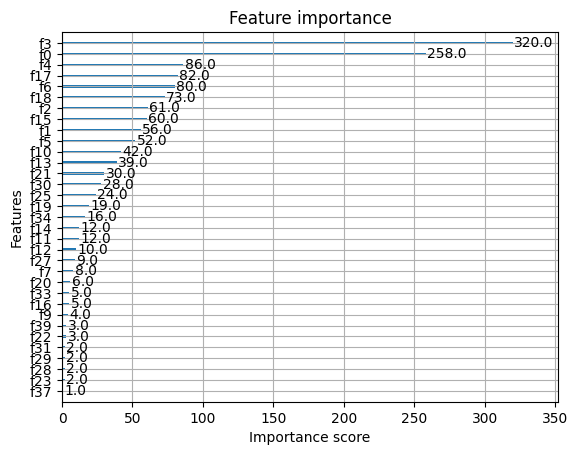

In [74]:
xgb.plot_importance(best_model.named_steps['classifier'])
plt.show()

In [75]:
# Evaluate on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [76]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [77]:
print(f"Best Parameters: {grid_search.best_params_}")
print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}

Model Evaluation Metrics:
Accuracy: 0.5032
Precision: 0.4881
Recall: 0.9987
F1 Score: 0.6557
ROC AUC: 0.7383


In [78]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.06      0.11     33881
           1       0.49      1.00      0.66     30493

    accuracy                           0.50     64374
   macro avg       0.73      0.53      0.38     64374
weighted avg       0.75      0.50      0.37     64374



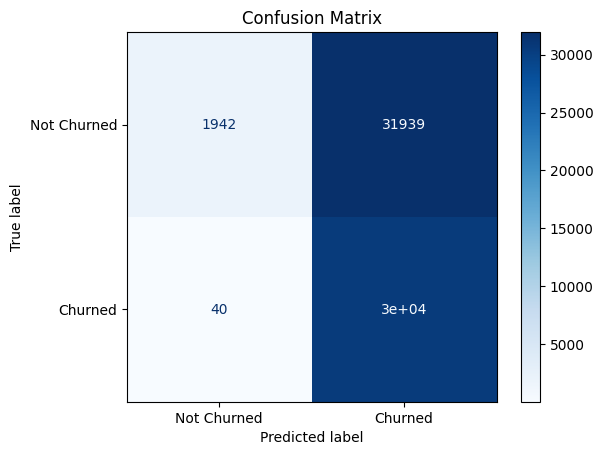

In [79]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [80]:
# Feature importance
preprocessor = best_model.named_steps['preprocessor']
feature_names = numeric_features.copy()

In [81]:
# Add one-hot encoded categorical feature names
ohe_columns = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
feature_names.extend(ohe_columns)

In [82]:
# Get feature importances
importances = best_model.named_steps['classifier'].feature_importances_

In [83]:
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

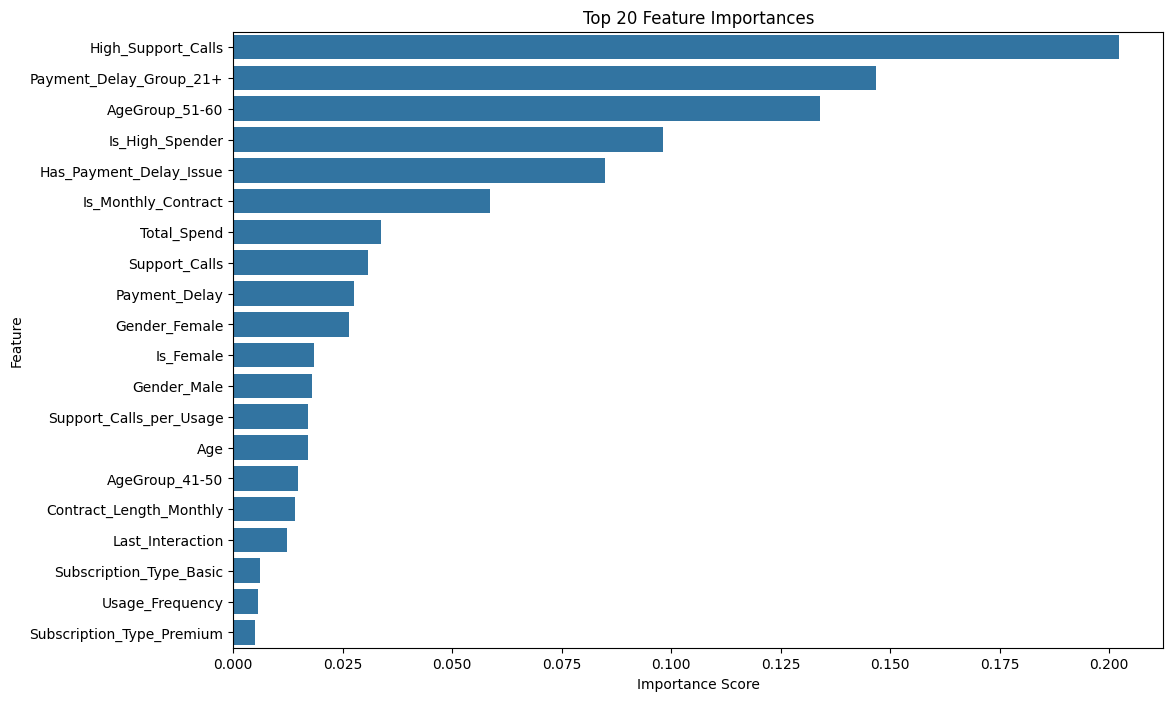

In [84]:
# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# =============================================
# VALIDATE KEY EDA INSIGHTS IN MODEL
# =============================================

## 1. High support calls (>5 should predict churn)

In [85]:
high_support_mask = X_test['Support_Calls'] > 5

print("\n=== Key Insight Validation ===")
if high_support_mask.any():
    print(f"\nAccuracy on High Support Calls (>5): {accuracy_score(y_test[high_support_mask], y_pred[high_support_mask]):.2f}")
    print(f"Churn Rate in High Support Calls: {y_test[high_support_mask].mean():.2f}")
    print(f"Model Predicted Churn Rate: {y_pred[high_support_mask].mean():.2f}")


=== Key Insight Validation ===

Accuracy on High Support Calls (>5): 0.61
Churn Rate in High Support Calls: 0.61
Model Predicted Churn Rate: 1.00


## 2. Age group 20-30 and >60

In [86]:
for age_range, condition in [('20-30', X_test['Age'].between(20, 30)),
                             ('60+', X_test['Age'] > 60)]:
    if condition.any():
        print(f"\n{age_range} Age Group:")
        print(f"Actual Churn Rate: {y_test[condition].mean():.2f}")
        print(f"Model Recall: {recall_score(y_test[condition], y_pred[condition]):.2f}")


20-30 Age Group:
Actual Churn Rate: 0.44
Model Recall: 1.00

60+ Age Group:
Actual Churn Rate: 0.53
Model Recall: 1.00


## 3. Female customers

In [87]:
female_mask = X_test['Gender'] == 'Female'
print(f"\nFemale Customers:")
print(f"Actual Churn Rate: {y_test[female_mask].mean():.2f}")
print(f"Model Precision: {precision_score(y_test[female_mask], y_pred[female_mask]):.2f}")


Female Customers:
Actual Churn Rate: 0.55
Model Precision: 0.56


## 4. Monthly contracts

In [88]:
monthly_mask = X_test['Contract_Length'] == 'Monthly'
print(f"\nMonthly Contracts:")
print(f"Actual Churn Rate: {y_test[monthly_mask].mean():.2f}")
print(f"Model Recall: {recall_score(y_test[monthly_mask], y_pred[monthly_mask]):.2f}")


Monthly Contracts:
Actual Churn Rate: 0.52
Model Recall: 1.00
